<a href="https://colab.research.google.com/github/lakshanravi/langgraph-workflow-agents/blob/main/langgraph_stage_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain==0.3.24 -q
!pip install langchain-google-genai -q
!pip install langchain-community -q
!pip install langgraph -q

# !pip install langchain-tavily -q
# !pip install pyowm -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.9/458.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 21.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 1.0.7 requires langchain-core>=1.0.0, but you have langchain-core 0.3.83 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.2/502.2 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

In [3]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [4]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:
import os
from google.colab import userdata


os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')



In [6]:
# Initialize the ChatOpenAI model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0
)

In [8]:
# from langchain_tavily import TavilySearch
# from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.tools import tool
@tool
def addtion(a: int, b:int):
    """This is the addition function that adds 2 numbers"""
    return a + b

@tool
def subtraction(a: int, b: int):
    """This is the subtraction function that subtract 2 numbers"""
    return a - b

@tool
def multiplication(a: int, b: int):
    """This is the multiplication function that multiply 2 numbers"""
    return a * b

@tool
def division(a: int, b: int):
    """This is the division function that divide 2 numbers"""
    return a / b

# os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHERMAP_API_KEY')
# os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

# # Initialize DuckDuckGo search tool
# search_tool = TavilySearch()

# # Initialize OpenWeatherMap tool
# weather = OpenWeatherMapAPIWrapper()

# weather_tool = load_tools(["openweathermap-api"], llm)[0]

In [9]:
tools = [addtion, subtraction, multiplication, division]
# tools = [search_tool, weather_tool]

In [15]:
#Here are the tools you’re allowed to call. we need to pass tool list here.
#now LLM can call tools by himself
llm_with_tools = llm.bind_tools(tools)

In [16]:
#This function sends the system instruction plus the current conversation  to the LLM, gets the AI’s response, and returns that response as the new state.
#functions for nodes. for use tools
def llm_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are an intelligent AI assistant."
    )
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

#This function checks the last AI message, and if it contains a tool call it tells the workflow to continue to the tool node, otherwise it ends the conversation.
def decision(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [21]:
graph = StateGraph(AgentState)

graph.add_node("agent", llm_call)

#this is another node for use tools
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("agent")

#created decision. if it got "continue" it again use tools. otherwise flow is end
graph.add_conditional_edges(
    "agent",
    decision,
    {
        "continue": "tools",
        "end": END,
    },
)
graph.add_edge("tools", "agent")

app = graph.compile()

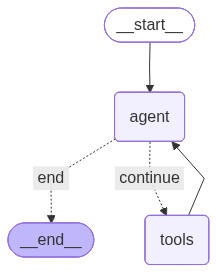

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [24]:
inputs = {"messages": [("user", "Add 40 and 12. Then multiply the result by 6.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 and 12. Then multiply the result by 6.
================================== Ai Message ==================================
Tool Calls:
  addtion (547f6d16-137f-49d1-be85-2b668c4a843b)
 Call ID: 547f6d16-137f-49d1-be85-2b668c4a843b
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: addtion

52
================================== Ai Message ==================================
Tool Calls:
  multiplication (9f209786-808c-4d97-890c-0318ce87da11)
 Call ID: 9f209786-808c-4d97-890c-0318ce87da11
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiplication

312
================================== Ai Message ==================================

The result is 312.


In [25]:
inputs = {"messages": [("user", "What is the current temperature in Colombo?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the current temperature in Colombo?
================================== Ai Message ==================================

I cannot provide the current temperature in Colombo as I do not have access to real-time weather information. My capabilities are limited to performing basic arithmetic operations.
